In [18]:
!{sys.executable} -m pip install gradio --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.2/20.2 MB 64.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.2/66.2 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.2/298.2 kB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.7/75.7 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 6.8 MB/s eta 0:

In [19]:
import random
import io
import pickle
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import text_to_word_sequence
from keras.utils import pad_sequences
import bs4 as bs
import urllib.request
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import gradio as gr

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
# Dataset
raw_html = urllib.request.urlopen('https://en.wikipedia.org/wiki/Democracy')
raw_html = raw_html.read()
article_html = bs.BeautifulSoup(raw_html, 'lxml')
article_paragraphs = article_html.find_all('p')
article_text = ''
for para in article_paragraphs:
    article_text += para.text
article_text = article_text.lower()

In [6]:
# Pre-procesamiento
def remove_stop_words(text):
  stop_words = set(stopwords.words('english'))
  word_tokens = word_tokenize(text.lower())
  filtered_sentence = [word for word in word_tokens if word not in stop_words]
  filtered_text = ' '.join(filtered_sentence)
  return filtered_text

sentences = sent_tokenize(article_text)
sentence_tokens = []
for sent in sentences:
  sent = remove_stop_words(sent)
  sentence_tokens.append(text_to_word_sequence(sent))

In [12]:
# Training dataset
train_len = 4
text_sequences = []
for sent in sentence_tokens:
  for i in range(train_len, len(sent)):
    seq = sent[i-train_len:i]
    text_sequences.append(seq)

tok = Tokenizer()
tok.fit_on_texts(text_sequences)
sequences = tok.texts_to_sequences(text_sequences)

arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1]
vocab_size = len(tok.word_counts)
y_data = to_categorical(y_data_int, num_classes=vocab_size)
y_data_int_offset = y_data_int - 1
y_data = to_categorical(y_data_int_offset, num_classes=vocab_size)

In [13]:
# Construccion del modelo
input_seq_len = x_data.shape[1]
output_size = vocab_size

model = Sequential()
model.add(Embedding(input_dim=vocab_size+1, output_dim=5, input_length=input_seq_len))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64)) # La última capa LSTM no lleva return_sequences
model.add(Dense(32, activation='relu'))
model.add(Dense(vocab_size, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3, 5)              15215     
                                                                 
 lstm (LSTM)                 (None, 3, 64)             17920     
                                                                 
 dropout (Dropout)           (None, 3, 64)             0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 3042)              100386    
                                                                 
Total params: 168625 (658.69 KB)
Trainable params: 16862

In [14]:
# Training
hist = model.fit(x_data, y_data, epochs=50, validation_split=0.2)

Epoch 1/50
148/148 [==============================] - 8s 21ms/step - loss: 7.8090 - accuracy: 0.0261 - val_loss: 8.0261 - val_accuracy: 0.0187
Epoch 2/50
148/148 [==============================] - 2s 13ms/step - loss: 7.2695 - accuracy: 0.0276 - val_loss: 8.5835 - val_accuracy: 0.0187
Epoch 3/50
148/148 [==============================] - 3s 22ms/step - loss: 7.1162 - accuracy: 0.0276 - val_loss: 8.8416 - val_accuracy: 0.0187
Epoch 4/50
148/148 [==============================] - 4s 26ms/step - loss: 7.0164 - accuracy: 0.0276 - val_loss: 9.1366 - val_accuracy: 0.0195
Epoch 5/50
148/148 [==============================] - 3s 23ms/step - loss: 6.9463 - accuracy: 0.0278 - val_loss: 9.5340 - val_accuracy: 0.0195
Epoch 6/50
148/148 [==============================] - 4s 25ms/step - loss: 6.8604 - accuracy: 0.0278 - val_loss: 9.6095 - val_accuracy: 0.0187
Epoch 7/50
148/148 [==============================] - 5s 34ms/step - loss: 6.7908 - accuracy: 0.0280 - val_loss: 10.1234 - val_accuracy: 0.018

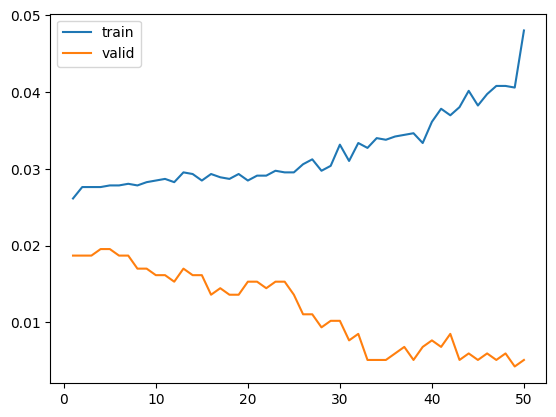

In [16]:
# Entrenamiento - resultados
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

In [22]:
# Generacion de secuencias
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    output_text = seed_text
    for _ in range(n_words):
        encoded = tokenizer.texts_to_sequences([output_text])[0]
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

        y_hat = model.predict(encoded).argmax(axis=-1)
        out_word = ''
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break
        output_text += ' ' + out_word
    return output_text


In [36]:
input_text='politics is the set'
generate_seq(model, tok, input_text, max_length=3, n_words=2)

1/1 [==============================] - 0s 72ms/step


'politics is the set decision '

In [29]:
input_text='a government is'
generate_seq(model, tok, input_text, max_length=3, n_words=2)

1/1 [==============================] - 0s 24ms/step


'a government is world '

In [41]:
input_text='political solution'
generate_seq(model, tok, input_text, max_length=3, n_words=2)

1/1 [==============================] - 0s 24ms/step


'political solution concludes offer'

In [42]:
input_text='democracy is '
generate_seq(model, tok, input_text, max_length=3, n_words=2)

1/1 [==============================] - 0s 22ms/step


'democracy is  called public'